In [1]:
import numpy as np 
from pathlib import Path
from src import utils, behavmatch, db
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 12
fs_title = 14
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI
from IPython.display import clear_output

In [2]:
areas = ["V1", "medial", "lateral", "anterior"]
ctypes = ["exc", "inh"]
corridor_length = 400
main_dir = Path(f"../data/notz/overall")

def dprime_cell(response, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = response[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

def select_neurons(m1, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m1.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool) if celltype == 'exc' else m1.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia

## collect sessions for first and last day of training

In [3]:
dbase = db.get_sessions()
fday = dbase.query("session == 'first training'")
lday = dbase.query("session == 'last training'")

In [4]:
lday

,mname,datexp,blk,session
2,VG11,2024_10_31,2,last training
6,VG11,2024_11_14,2,last training
10,VG14,2024_11_21,2,last training
14,VG15,2024_10_31,2,last training
18,VG21,2025_07_17,3,last training
22,VG24,2025_07_10,2,last training


Load data from first and last training day and computing the coding directions.

In [36]:
mice = []
for i, row in fday.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    mice.append(m)
    clear_output(wait=True)
print("first training sessions loaded")

first training sessions loaded


In [ ]:
non_matched_cds = np.empty((len(mice), 4, len(areas), len(ctypes), corridor_length)) # mice, ttype, areas, cell types, positions
main_dir = Path(f"../data/notz/overall")
for im, m in enumerate(mice):
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    ## Dprime selection trials
    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
    dp = dprime_cell(interp_spks, m.trial_dict["rewarded"][::2], m.trial_dict["non rewarded"][::2], discrimination_region=(0,100))
    nonmatched_dict = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
    for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
        for ct, c_type in enumerate(["exc", "inh"]):
            a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type, dprime=dp)
            cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
            for it, trials in enumerate(nonmatched_dict.values()):
                non_matched_cds[im, it, ia, ct] = cd[trials,:].mean(0)
np.save(main_dir/"cod_dirs_0_100_fristtraining.npy", non_matched_cds)

In [57]:
mice = []
for i, row in lday.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    mice.append(m)
    clear_output(wait=True)
print("last training sessions loaded")

last training sessions loaded


In [ ]:
non_matched_cds = np.empty((len(mice), 4, len(areas), len(ctypes), corridor_length)) # mice, ttype, areas, cell types, positions
main_dir = Path(f"../data/notz/overall")
for im, m in enumerate(mice):
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    ## Dprime selection trials
    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
    dp = dprime_cell(interp_spks, m.trial_dict["rewarded"][::2], m.trial_dict["non rewarded"][::2], discrimination_region=(0,100))
    nonmatched_dict = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
    for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
        for ct, c_type in enumerate(["exc", "inh"]):
            a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type, dprime=dp)
            cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
            for it, trials in enumerate(nonmatched_dict.values()):
                non_matched_cds[im, it, ia, ct] = cd[trials,:].mean(0)
np.save(main_dir/"cod_dirs_0_100_lasttraining.npy",non_matched_cds)

In [5]:
main_dir = Path(f"../data/overall")
first_day_cds = np.load(main_dir / "first_training" / "cod_dirs_0_100_updated.npy")
last_day_matched_cds = np.load(main_dir / "last_training" / "cod_dirs_0_100_matched_updated.npy")
last_day_cds = np.load(main_dir / "last_training" / "cod_dirs_0_100_updated.npy")

In [38]:
def plot_cds(day_response, ttype, area, ctype, ax, references=True):
    from scipy.stats import sem
    """ 
    Plot the mean and SEM of the coding direction for a given trial type, area, and cell type.
    Parameters
    ----------
    day_response : np.ndarray
        The coding direction data for the day. Shape: (n_mice, n_trial_types, n_areas, n_cell_types, corridor_length)
    ttype : int
        The trial type index (0: rewarded, 1: non-rewarded, 2: rewarded test, 3: non-rewarded test).
    area : int
        The area index (0: V1, 1: medial, 2: lateral, 3: anterior).
    ctype : int
        The cell type index (0: excitatory, 1: inhibitory).
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    nmice, ntrial_types, nareas, ncelltypes, corridor_length = day_response.shape
    mean_response = np.mean(day_response, axis=0)
    sem_response = sem(day_response, axis=0)
    ax.plot(mean_response[ttype, area, ctype], color=trial_type_palette[ttype], linewidth=2)
    ax.fill_between(np.arange(corridor_length), mean_response[ttype, area, ctype] - sem_response[ttype, area, ctype],
                                mean_response[ttype, area, ctype] + sem_response[ttype, area, ctype],
                                color=trial_type_palette[ttype], alpha=0.2)
    if references:
        ax.axvline(x=150, color='gray', linestyle='--', alpha=0.2)
        ax.axvline(x=300, color='gray', linestyle='--', alpha=0.2)

def compute_gi(avgs_coding_dirs, pos):
    """
    Compute the GI for each cell type and area.
    GI = |cyan - orange| / |green - red|

    avgs_coding_dirs: array of shape (mice, ttype, area, cell type, positions)
    """
    gis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    dis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    gen = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    avgs_coding_dirs = avgs_coding_dirs[:,:,:,:,:pos].mean(-1) #mouse, ttype, area, cell type, positions
    for area in range(4):
        for cell_type in range(2):
            gen[:, area, cell_type] = avgs_coding_dirs[:,2,area,cell_type] - avgs_coding_dirs[:,3,area,cell_type]
            dis[:, area, cell_type] = avgs_coding_dirs[:,0,area,cell_type] - avgs_coding_dirs[:,1,area,cell_type]
            for m in range(avgs_coding_dirs.shape[0]):
                if (dis[m, area, cell_type] < 0) and (gen[m, area, cell_type] < 0):
                    gis[m, area, cell_type] = np.abs(gen[m, area, cell_type]) / np.abs(dis[m, area, cell_type]) * -1
                else:
                    gis[m, area, cell_type] = gen[m, area, cell_type] / dis[m, area, cell_type]
    return gis, dis, gen

def compute_gi_bin(avgs_coding_dirs, bin):
    """
    Compute the GI for each cell type and area.
    GI = |cyan - orange| / |green - red|

    avgs_coding_dirs: array of shape (mice, ttype, area, cell type, positions)
    """
    gis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    dis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    gen = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    avgs_coding_dirs = avgs_coding_dirs[:,:,:,:,bin[0]:bin[1]].mean(-1) #mouse, ttype, area, cell type, positions
    for area in range(4):
        for cell_type in range(2):
            gen[:, area, cell_type] = avgs_coding_dirs[:,2,area,cell_type] - avgs_coding_dirs[:,3,area,cell_type]
            dis[:, area, cell_type] = avgs_coding_dirs[:,0,area,cell_type] - avgs_coding_dirs[:,1,area,cell_type]
            for m in range(avgs_coding_dirs.shape[0]):
                if (dis[m, area, cell_type] < 0) and (gen[m, area, cell_type] < 0):
                    gis[m, area, cell_type] = np.abs(gen[m, area, cell_type]) / np.abs(dis[m, area, cell_type]) * -1
                else:
                    gis[m, area, cell_type] = gen[m, area, cell_type] / dis[m, area, cell_type]
    return gis, dis, gen

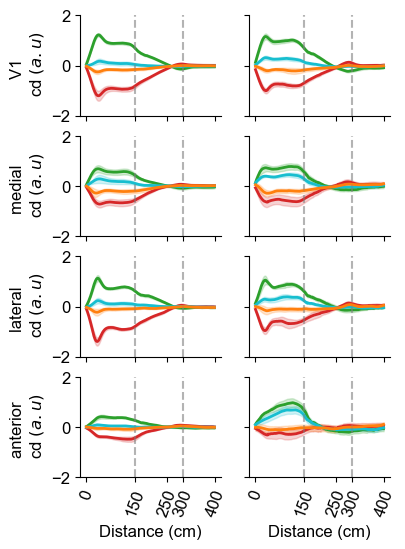

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(4, 6), sharex=True, sharey=True)
for iday, day_response in enumerate([first_day_cds, last_day_matched_cds]):
    ax[-1,iday].set_xlabel('Distance (cm)')
    ax[-1,iday].set_xticks([0, 150, 250, 300, 400])
    for ttype in range(4):
        for a, area in enumerate(areas):
            plot_cds(day_response, ttype, a, 0, ax[a,iday], references=True)
            ax[a,iday].set_ylim(-2,2)
            if iday == 0:
                ax[a,iday].set_ylabel(f"{areas[a]} \n cd $(a.u)$", loc='center')
                #rotate xticks
            for tick in ax[a,iday].get_xticklabels():
                tick.set_rotation(70)

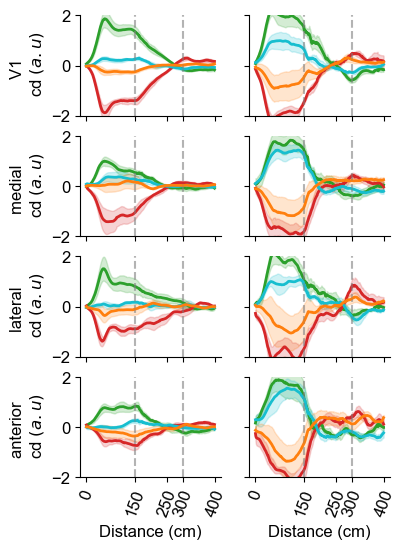

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(4, 6), sharex=True, sharey=True)
for iday, day_response in enumerate([first_day_cds, last_day_matched_cds]):
    ax[-1,iday].set_xlabel('Distance (cm)')
    ax[-1,iday].set_xticks([0, 150, 250, 300, 400])
    for ttype in range(4):
        for a, area in enumerate(areas):
            plot_cds(day_response, ttype, a, 1, ax[a,iday], references=True)
            ax[a,iday].set_ylim(-2,2)
            if iday == 0:
                ax[a,iday].set_ylabel(f"{areas[a]} \n cd $(a.u)$", loc='center')
                #rotate xticks
            for tick in ax[a,iday].get_xticklabels():
                tick.set_rotation(70)

In [17]:
gis_first, dis_first, gen_first = compute_gi(first_day_cds, 100)
gis_last_m, dis_last_m, gen_last_m = compute_gi(last_day_matched_cds, 100)
gis_last, dis_last, gen_last = compute_gi(last_day_cds, 100)

In [18]:
def significance(pval):
    if  pval >= .05:
        sig = ''
    elif (pval < .05) and (pval >= .01):
        sig = '*'
    elif (pval < .01) and (pval >= .001):
        sig = '**'
    elif (pval < .001) and (pval >= .0001):
        sig = '***'
    else:
        sig = '****'
    return sig

In [20]:
def plot_gi_comparison(gis_sess, n_sess, labels, ax):
    """
    Plot the GI comparison between the first and last training sessions.
    Parameters
    ----------
    gis_sess : np.ndarray
        The GI data for the first and last training sessions. Shape: (sess*day, areas, ctypes)
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    from scipy.stats import ttest_rel, sem
    for a in range(4):
        for ctp in range(2):
            day_one_r = gis_sess[:n_sess, a, ctp]
            day_two_r = gis_sess[n_sess:, a, ctp]
            mean_day_one = np.mean(day_one_r, axis=0)
            mean_day_two = np.mean(day_two_r, axis=0)
            sem_day_one = sem(day_one_r, axis=0)
            sem_day_two = sem(day_two_r, axis=0)
            ax[ctp].scatter(a-.1, mean_day_one, color='gray', alpha=1, s=10)
            ax[ctp].scatter(a+.1, mean_day_two, color='k', alpha=1, s=20)
            ax[ctp].errorbar(a-.1, mean_day_one, yerr=sem_day_one, color='gray', alpha=1)
            ax[ctp].errorbar(a+.1, mean_day_two, yerr=sem_day_two, color='k', alpha=1)
            ax[ctp].set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'])
            
            ax[ctp].axhline(y=0, color='gray', linestyle='--', alpha=0.2)
            if ctp == 0:
                ax[ctp].set_ylabel('Invariance Index $(a.u.)$')
                ax[ctp].set_yticks([0,.25,.5,.75, 1, 1.25])
                ax[ctp].set_title("excitatory")
            else:
                ax[ctp].set_title("inhibitory")
            t, p = ttest_rel(day_two_r, day_one_r, alternative='greater')
            p_t = significance(p)
            ax[ctp].text(a, 1, p_t, ha='center', va='center', color='k', fontsize=20, transform=ax[ctp].transData)

            # connect lines between every sample point and each day
            for m in range(6):
                ax[ctp].plot([a-.1, a+.1], [day_one_r[m], day_two_r[m]], color='k', linewidth=.5, alpha=0.4)

    ax[-1].text(1.1, .85, labels[0], ha='left', color='gray', transform=ax[-1].transAxes)
    ax[-1].text(1.1, .75, labels[1], ha='left', color='k',transform=ax[-1].transAxes)
    plt.tight_layout()

In [21]:
def plot_gi_comparison_wcontrol(first_gi, second_gi, control_gi, ax):
    """
    Plot the GI comparison between the first and last training sessions.
    Parameters
    ----------
    gis_sess : np.ndarray
        The GI data for the first and last training sessions. Shape: (sess*day, areas, ctypes)
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    from scipy.stats import ttest_rel, sem
    colors = ["#b1afcf",'#756bb1',"#9691c7"]
    offset = [-0.1, 0.1, 0.3] # offset for the first, second and control GI
    labels = ['first day', 'last day (behavior matched)', 'last day (all trials)']
    for i_gi, gi in enumerate([first_gi, second_gi, control_gi]):
        for a in range(4):
            for ctp in range(2):
                mean = np.mean(gi[:, a, ctp], axis=0)
                sem_ = sem(gi[:, a, ctp], axis=0)
                ax[ctp].scatter(a+offset[i_gi], mean, color=colors[i_gi], alpha=1, s=20)
                ax[ctp].errorbar(a+offset[i_gi], mean, yerr=sem_, color=colors[i_gi], alpha=1)
                ax[ctp].set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'])
                ax[ctp].axhline(y=0, color='gray', linestyle='--', alpha=0.2)
                if ctp == 0:
                    ax[ctp].set_ylabel('Invariance Index $(a.u.)$')
                    ax[ctp].set_yticks([0,.25,.5,.75, 1, 1.25])
    ax[0].text(0.05, .12, "first day", ha='left', color=colors[0], transform=ax[0].transAxes, fontsize=10)
    ax[0].text(0.05, .07, "last day (matched)", ha='left', color=colors[1],transform=ax[0].transAxes, fontsize=10)
    ax[0].text(0.05, .02, "last day (all trials)", ha='left', color=colors[2], transform=ax[0].transAxes, fontsize=10)

    for a in range(4):
        for ctp in range(2):
            day_one_r = first_gi[:, a, ctp]
            day_two_r = second_gi[:, a, ctp]
            control_r = control_gi[:, a, ctp]
            t, p = ttest_rel(day_two_r, day_one_r, alternative='greater')
            p_t = significance(p)
            if p<.05:
                ax[ctp].text(a, 1, p_t, ha='center', va='center', color='k', fontsize=15, transform=ax[ctp].transData)
                # a line between one category and the other
                from matplotlib.lines import Line2D
                line = Line2D([a-.1, a+.1], [1, 1], color='k', linewidth=1, alpha=1)
                ax[ctp].add_line(line)
            t, p = ttest_rel(control_r, day_one_r, alternative='greater')
            p_t = significance(p)
            if p<.05:
                ax[ctp].text(a+.1, 1.15, p_t, ha='center', va='center', color='k', fontsize=15, transform=ax[ctp].transData)
                # a line between one category and the other
                from matplotlib.lines import Line2D
                line = Line2D([a-.1, a+.3], [1.15, 1.15], color='k', linewidth=1, alpha=1)
                ax[ctp].add_line(line)
            for m in range(6):
                ax[ctp].plot([a-.1, a+.1], [day_one_r[m], day_two_r[m]], color='k', linewidth=.5, alpha=0.4)

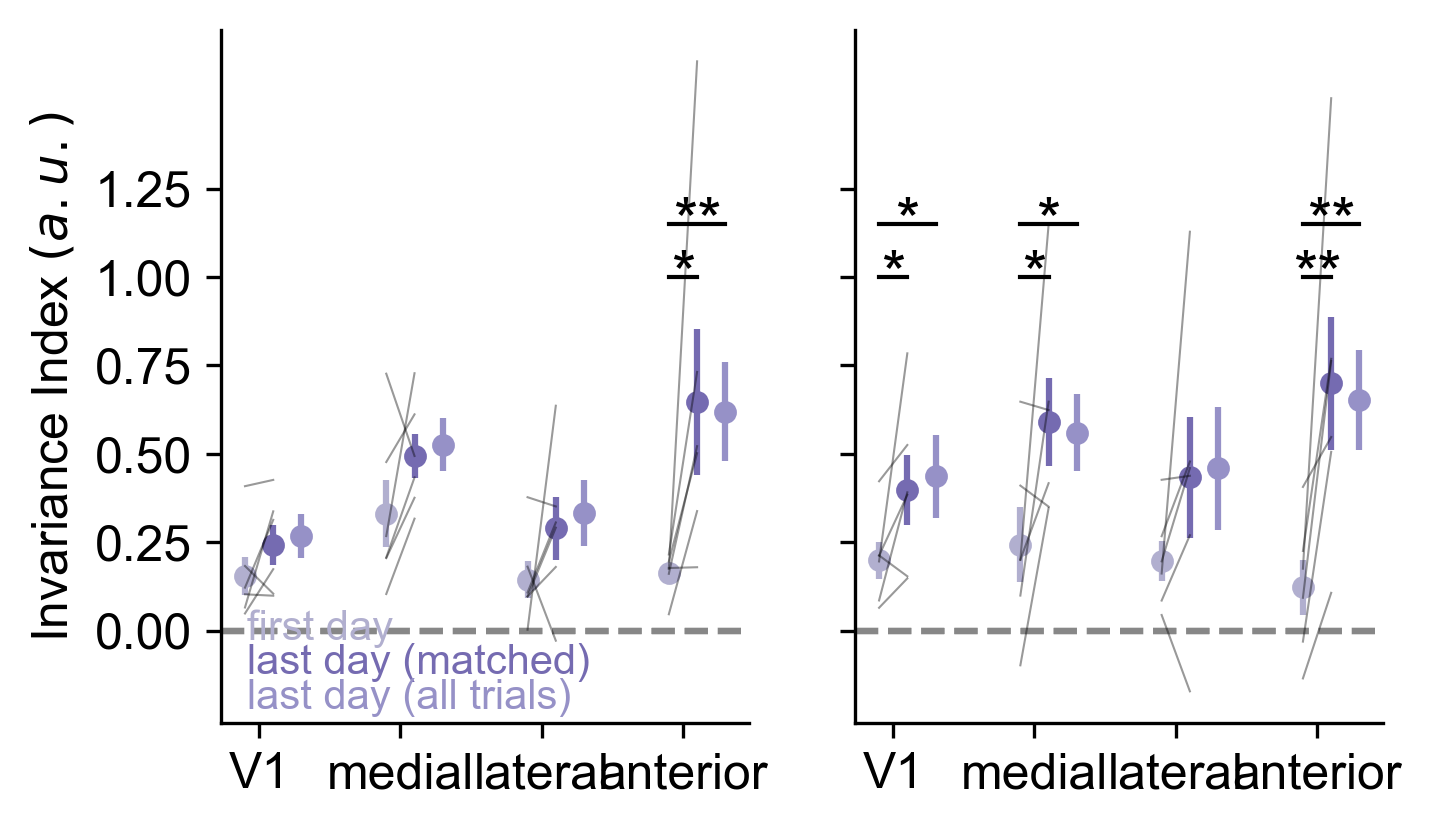

In [22]:
gis_first, dis_first, gen_first = compute_gi(first_day_cds, 100)
gis_last_m, dis_last_m, gen_last_m = compute_gi(last_day_matched_cds, 100)
gis_last, dis_last, gen_last = compute_gi(last_day_cds, 100)
fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True, dpi=300)
plot_gi_comparison_wcontrol(gis_first, gis_last_m, gis_last, ax)

In [35]:
def compute_gi_bins(first_day_cds, last_day_matched_cds, binsize=25, corridor_lim=400):
    bins = np.arange(binsize, corridor_lim+1, binsize)
    nbins = len(bins)
    gis_first_bin = np.empty((nbins, 6, 4, 2))
    gis_last_bin = np.empty((nbins, 6, 4, 2))
    for i, pos in enumerate(bins):
        gis_first, dis_first, gen_first = compute_gi(first_day_cds, pos)
        gis_last, dis_last, gen_last = compute_gi(last_day_matched_cds, pos)
        gis_first_bin[i] = gis_first
        gis_last_bin[i] = gis_last
    return gis_first_bin, gis_last_bin, bins

In [36]:
gis_first_bin, gis_last_bin, bins = compute_gi_bins(first_day_cds, last_day_matched_cds, binsize=25, corridor_lim=150)

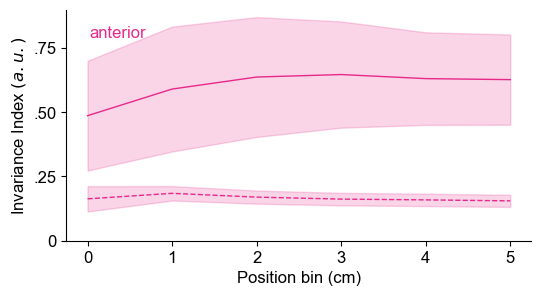

In [31]:
a = 3
i = 0
errorbars = False
fig, ax = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True)
def plot_cumulative_gi(ax, gis_first_bin, gis_last_bin, a, i, errorbars=True, xlabel=None, ylabel=None, title=None, legend=False):
    """
    Plot the cumulative GI for a given area and cell type.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    gis_last_bin : np.ndarray
        The GI data for the last training session. Shape: (nbins, areas, cell types).
    gis_first_bin : np.ndarray  
        The GI data for the first training session. Shape: (nbins, areas, cell types).
    a : int
        Index of the area to plot.
    i : int
        Index of the cell type to plot.
    errorbars : bool
        Whether to plot error bars or not.
    xlabel : str or None
        Label for the x-axis. If None, no label is set.
    ylabel : str or None
        Label for the y-axis. If None, no label is set.
    """
    gis_first_bin_mean = gis_first_bin.mean(1)
    gis_last_bin_mean = gis_last_bin.mean(1)
    gis_first_bin_sem = sem(gis_first_bin, axis=1)
    gis_last_bin_sem = sem(gis_last_bin, axis=1)
    nbins = gis_last_bin_mean.shape[0]
    xrange = np.arange(nbins)
    cmap = ['#1b9e77','#d95f02','#7570b3','#e7298a']
    areas = ["V1", "medial", "lateral", "anterior"]
    if errorbars:
        ax.errorbar(xrange, gis_last_bin_mean[:,a,i], yerr=gis_last_bin_sem[:,a,i], linewidth=1, capsize=3, color=cmap[a], linestyle="None")
        ax.scatter(xrange, gis_last_bin_mean[:,a,i], linewidth=1, label="last day (matched)", color=cmap[a], marker='x')
        ax.scatter(xrange, gis_first_bin_mean[:,a,i], color=cmap[a], linewidth=1, label=f"first day")
        ax.errorbar(xrange, gis_first_bin_mean[:,a,i], yerr=gis_first_bin_sem[:,a,i], linewidth=1, capsize=3, color=cmap[a], linestyle="None")
    else:
        ax.plot(xrange, gis_last_bin_mean[:,a,i], linewidth=1, label=f"last day (matched)", color=cmap[a])
        ax.fill_between(xrange, 
                        gis_last_bin_mean[:,a,i] - gis_last_bin_sem[:,a,i], 
                        gis_last_bin_mean[:,a,i] + gis_last_bin_sem[:,a,i], 
                        color=cmap[a], alpha=0.2)
        ax.plot(xrange, gis_first_bin_mean[:,a,i], color=cmap[a], linewidth=1, label=f"first day", linestyle="--")
        ax.fill_between(xrange, 
                        gis_first_bin_mean[:,a,i] - gis_first_bin_sem[:,a,i], 
                        gis_first_bin_mean[:,a,i] + gis_first_bin_sem[:,a,i], 
                        color=cmap[a], alpha=0.2)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel('Invariance Index $(a.u.)$')
    else:
        ax.tick_params(labelleft=False)
    if title is not None:
        ax.set_title(areas[a], loc='center')
    #if legend:
    #    ax.text(nbins-1 + .2, gis_last_bin_mean[-1,a,i], "last day (matched)", ha='left', va='center')
    #    ax.text(nbins-1 + .2, gis_first_bin_mean[-1,a,i], "first day", ha='left', va='center')
    ax.text(0.05, 0.9, areas[a], ha='left', va='center', color=cmap[a], transform=ax.transAxes)
    ax.set_ylim(0,.9)
    ax.set_yticks([0,.25,.5,.75], ["0", ".25", ".50", ".75"])
plot_cumulative_gi(ax, gis_first_bin, gis_last_bin, a, i, errorbars=errorbars, xlabel='Position bin (cm)', ylabel='Invariance Index $(a.u.)$', legend=True)

In [33]:
first_day_cds.shape

(6, 4, 4, 2, 400)

In [ ]:
compute_gi_bin

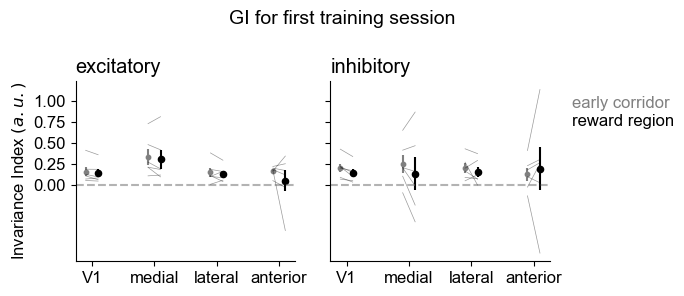

In [40]:
gis_first_bin, dis_first, gen_first = compute_gi_bin(first_day_cds, (150, 250))
gis_first, dis_first, gen_first = compute_gi(first_day_cds, 100)
fig, ax = plt.subplots(1, 2, figsize=(7,3), sharex=True, sharey=True)
gis_sess = np.vstack((gis_first, gis_first_bin))
plot_gi_comparison(gis_sess,6,("early corridor", "reward region"), ax)
plt.suptitle("GI for first training session", fontsize=fs_title)
plt.tight_layout()

In [18]:
def lick_averages(df, ax, lines=True, stat_test=False, alpha=1, offset=0, ylabel = True, **kwargs):
    from scipy import stats
    data = df[["rewarded", "non rewarded", "rewarded test", "non rewarded test"]]
    lick_rate = pd.melt(data, var_name="trial_type", value_name="lick_rate")
    lick_rate["trial_type"] = lick_rate["trial_type"].map({"rewarded": "Prototype A", "non rewarded": "Prototype B", "rewarded test": "Rest of A", "non rewarded test": "Rest of B"})
    if stat_test:
        #print(stats.f_oneway(data['rewarded'], data['non rewarded'], data['rewarded test'], data['non rewarded test']))
        import scikit_posthocs as sp
        res = sp.posthoc_ttest(lick_rate, val_col='lick_rate', group_col='trial_type', p_adjust='holm')
        #print(np.round(res,4))
    if lines:
        for i, row in data.iterrows():
            ax.plot([1, 2], [row['rewarded'], row['non rewarded']], '-', alpha=0.1, color='gray')
            ax.plot([3, 4], [row['rewarded test'], row['non rewarded test']], '-', alpha=0.1, color='gray')
    cmap = {"rewarded": 'tab:green', "non rewarded": 'tab:red', "rewarded test": 'tab:cyan', "non rewarded test": 'tab:orange'}
    for i, column in enumerate(['rewarded', 'non rewarded', 'rewarded test', 'non rewarded test'], start=1):
        mean = data[column].mean()
        median = data[column].median()
        c = cmap[column]
        ax.errorbar(i+offset, mean, yerr=stats.sem(data[column]), color=c, alpha=alpha, zorder=0)
        ax.plot(i+offset, median, '_', color=c, markersize=13, markeredgewidth=2, alpha=alpha, zorder=1)
        ax.plot(i+offset, mean, '8', color=c, markersize=5, markerfacecolor='white',  alpha=alpha, zorder=0)
    from matplotlib.lines import Line2D
    comparisons = [(0,1), (2,3)]
    xcoor = []
    ycoor = []
    pvals = []
    yval = 1
    for comp in comparisons:
        if res.iloc[comp[0], comp[1]] < 0.05:
            xcoor.append([comp[0]+1, comp[1]+1])
            ycoor.append(yval)
            yval += 0.03
            pvals.append(significance(res.iloc[comp[0], comp[1]]))
    #xcoor = [[1,4], [1,3], [1,2], [2,3], [3,4]]
    #ycoor = [1.14, 1.09, 1.04, 1.02, 1]
    fig = plt.gcf()
    lines = [Line2D(x, [y,y], color='k', linewidth=.5, transform=ax.transData, figure=fig) for x,y in zip(xcoor, ycoor)]
    for x,y,text in zip(xcoor, ycoor, pvals):
        ax.text(np.mean(x), y, text, ha='center', va='center', transform=ax.transData, fontsize=12)
    for line in lines:
        fig.add_artist(line)
    if ylabel:
        ax.set_ylabel("% trials with licks")
    ax.set_xticks([1, 2, 3, 4])
    if "xtickslabels" in kwargs:
        ax.set_xticklabels(kwargs["xtickslabels"])
    else:
        ax.set_xticklabels(["Prot \n A", "Prot \n B", "Rest \n A", "Rest \n B"])
    ax.set_yticks([0,.25, .5, .75, 1], [0, 25, 50, 75, 100])

In [19]:
behavior_df = pd.read_csv("../data/overall/behavior_df.csv")
overall_acc = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\overall_acc.npy"))
overall_betas = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\overall_betas.npy"))
overall_prob = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\overall_probs.npy"), allow_pickle=True)
first100df = pd.read_csv(r"C:\Users\labadmin\Documents\GeneralizationPaper\Figure1\all_sessions_150_250_first100.csv", index_col=0)
corridor_length = 400
bsize = 25
n_bins = corridor_length // bsize
n_cov = 6
reg_names = ["Intercept", "Lick rate", "Speed", "Acceleration", "$\Delta$ Pupil", "$\Delta$ Motion"]
matched_features = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\matched_feature_means.npy"))
non_matched_features = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\nonmatched_feature_means.npy"))
f_labels = ["Lick rate ($Hz$)", "Speed ($cms^{-1}$)", "Acc ($cm s^{-2}$)", "%$\Delta$ Face motion", "%$\Delta$ Pupil size"]
selected_features = [0, 1, 4]
nfeatures = matched_features.shape[1]
gis_first, dis_first, gen_first = compute_gi(first_day_cds, 100)
gis_last_m, dis_last_m, gen_last_m = compute_gi(last_day_matched_cds, 100)
gis_last, dis_last, gen_last = compute_gi(last_day_cds, 100)
gis_first_bin, gis_last_bin, bins = compute_gi_bins(first_day_cds, last_day_matched_cds, binsize=25, corridor_lim=150)
behavior_df = behavior_df.assign(DI = lambda x: x['rewarded'] - x['non rewarded'], 
                   GI_num = lambda x: x['rewarded test'] - x['non rewarded test'])

In [20]:
overall_prob[0].shape

(254, 16)

In [21]:

def plot_behav_dis(ax, behavior_df, first100df):
    """
    Plot the behavioral DI and GI_num for two tasks.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    behavior_df : pd.DataFrame
        The DataFrame containing the behavioral data for the second task.
    first100df : pd.DataFrame
        The DataFrame containing the behavioral data for the first task.
    """
    task1_xs = [-.1, .9]
    task2_xs = [.1, 1.1]
    xs = [task1_xs, task2_xs]
    colors = ["#939090","#383737"]
    labels = ["Task 1", "Task 2"]
    for it, task_df in enumerate([first100df, behavior_df]):
        di_mean = task_df['DI'].mean()
        di_sem = sem(task_df['DI'])
        gi_num_mean = task_df['GI_num'].mean()
        gi_num_sem = sem(task_df['GI_num'])
        xvals = xs[it]
        c = colors[it]
        ax.errorbar(x=xvals[0], y=di_mean, yerr=di_sem, color=c, alpha=1, capsize=3)
        ax.errorbar(x=xvals[1], y=gi_num_mean, yerr=gi_num_sem, color=c, alpha=1, capsize=3)
        ax.scatter(x=xvals[0], y=di_mean, color=c, alpha=1, s=20)
        ax.scatter(x=xvals[1], y=gi_num_mean, color=c, alpha=1, s=20)
        ax.text(.1, .3-(it*.1) -.05, labels[it], ha='left', va='center', color=c, transform=ax.transAxes, fontsize=10)
    ax.set_ylabel("Behavioral DI");
    ax.set_xticks([0,1], ["Prototypes", "Non \n Prototypes"]);
    ax.set_ylim(0,1)
    
def accuracy_plot(overall_acc, ax):
    """
    """
    corridor_length = 400
    bsize = 25
    n_bins = corridor_length // bsize
    avg_acc = np.mean(overall_acc, axis=0)
    sem_acc = sem(overall_acc, axis=0)
    xtickslabels = [":100", ":250", ":400"]
    ax.plot(range(0, n_bins), avg_acc, color='k', marker='o', markersize=1, linewidth=1)
    ax.fill_between(range(0, n_bins), avg_acc - sem_acc, avg_acc + sem_acc, color='k', alpha=0.2)
    ax.set_ylabel("Accuracy")
    ax.set_yticks([.5,.7,.9], [.5, .7, .9,])
    ax.set_xticks([3, 9, 15], xtickslabels)
    ax.set_xlabel("Position bin ($cm$)")
    ymin, ymax = ax.get_ylim()
    ax.fill_between(np.arange(4), ymin, ymax, color='gray', alpha=0.2)

def betas_plot(overall_betas, ax, legend=False):
    # get 6 colors from Dark2 color palette
    from matplotlib import cm
    cmap = cm.get_cmap('Set2', 6)
    colors = [cmap(i) for i in range(6)]
    avg_b = np.mean(overall_betas, axis=0)
    sem_b = sem(overall_betas, axis=0)
    xtickslabels = [":100", ":250", ":400"]
    for i in range(n_cov):
        ax.plot(range(0, n_bins), avg_b[i], label=reg_names[i], marker='o', markersize=1, color=colors[i], linewidth=1)
        ax.fill_between(range(0, n_bins), avg_b[i]-sem_b[i], avg_b[i]+sem_b[i], color=colors[i], alpha=0.2)
    ax.axhline(y=0, color='k', linestyle='--', alpha=1)
    ax.set_xticks([3, 9, 15], xtickslabels)
    ax.set_ylabel(r"$\beta$", rotation=0, labelpad=10)
    ax.set_xlabel("Position bin ($cm$)")
    ymin, ymax = ax.get_ylim()
    ax.fill_between(np.arange(4), ymin, ymax, color='gray', alpha=0.2)
    if legend:
        for i in range(n_cov):
            ax.text(1, .9-(i*.1), reg_names[i], ha='left', va='center', fontsize=8, color=colors[i], transform=ax.transAxes)
        #ax.legend(loc='upper left', fontsize=default_font, bbox_to_anchor=(1.05, 2), frameon=False)

def plot_catvsbehav(behav_cov_catA, behav_cov_catB, ylabel, xlabel, ax, legend=False):
    cat_a = behav_cov_catA
    cat_b = behav_cov_catB
    ax.plot(cat_a.mean(0), color='tab:green', linestyle='-', label='Category A')
    ax.fill_between(np.arange(400), cat_a.mean(0)-sem(cat_a, axis=0), cat_a.mean(0)+sem(cat_a, axis=0), alpha=0.3, color='tab:green')
    ax.plot(cat_b.mean(0), color='tab:red', linestyle='-', label='Category B')
    ax.fill_between(np.arange(400), cat_b.mean(0)-sem(cat_b, axis=0), cat_b.mean(0)+sem(cat_b, axis=0), alpha=0.3, color='tab:red')
    ax.set_ylabel(ylabel)
    ax.set_xticks([0, 150, 300, 400], ['0', '150', '300', '400'])    
    if legend:
        ax.legend(bbox_to_anchor=(1.05, .9), fontsize=default_font, frameon=False)
    if xlabel:
        ax.set_xlabel("Position ($cm$)")
    #fill between 0 and 100 with gray
    ymin, ymax = ax.get_ylim()
    ax.fill_between(np.arange(100), ymin, ymax, color='gray', alpha=0.2)
    ax.axvline(150, color='k', linestyle='--', alpha=0.3)
    ax.axvline(300, color='k', linestyle='--', alpha=0.3)

In [22]:
def move_axis(ax, left=True, down=True, left_dx=0, bottom_dx=0, width_dx=1, height_dx=1):
    poss = ax.get_position().bounds
    if left:
        new_left = poss[0] - left_dx
    else:
        new_left = poss[0] + left_dx
    if down:
        new_bottom = poss[1] - bottom_dx
    else:
        new_bottom = poss[1] + bottom_dx
    if width_dx != 1:
        new_width = poss[2] * width_dx
    else:
        new_width = poss[2]
    if height_dx != 1:
        new_height = poss[3] * height_dx
    else:
        new_height = poss[3]
    ax.set_position([new_left, new_bottom, new_width, new_height])


def move_axis_2(ax, hdx=0, vdx=0, widthdx=1, heightdx=1):
    poss = ax.get_position().bounds
    new_left = poss[0] + hdx
    new_bottom = poss[1] + vdx
    new_width = poss[2] * widthdx
    new_height = poss[3] * heightdx
    ax.set_position([new_left, new_bottom, new_width, new_height])

def show_image(ax, img_path):
    ax.imshow(plt.imread(img_path))
    ax.axis('off')

In [23]:
def add_panel_label(ax, label, x=0.01, y=0.99, **kwargs):
    """
    Add a label (e.g., 'A', 'B', ...) to the top left corner of an axis.
    Parameters:
        ax : matplotlib.axes.Axes
            The axis to label.
        label : str
            The label text.
        x, y : float
            Position in axis coordinates (default: top left).
        **kwargs : dict
            Additional arguments passed to ax.text (e.g., fontsize, fontweight).
    """
    ax.text(x, y, label, transform=ax.transAxes, ha='center', va='center', **kwargs)

In [24]:
import seaborn as sns

In [25]:
def create_axes(fig, grid, sharex=False, sharey=False):
    nrows, ncols = grid.get_geometry()
    axes = []
    for row in range(nrows):
        for col in range(ncols):
            if row == 0 and col == 0:
                ax = fig.add_subplot(grid[row, col])
                axes.append(ax)
            else: 
                if sharex and sharey:
                    ax = fig.add_subplot(grid[row, col], sharex=axes[0], sharey=axes[0])
                elif sharex:
                    ax = fig.add_subplot(grid[row, col], sharex=axes[0])
                elif sharey:
                    ax = fig.add_subplot(grid[row, col], sharey=axes[0])
                else:
                    ax = fig.add_subplot(grid[row, col])
                axes.append(ax)
    return axes

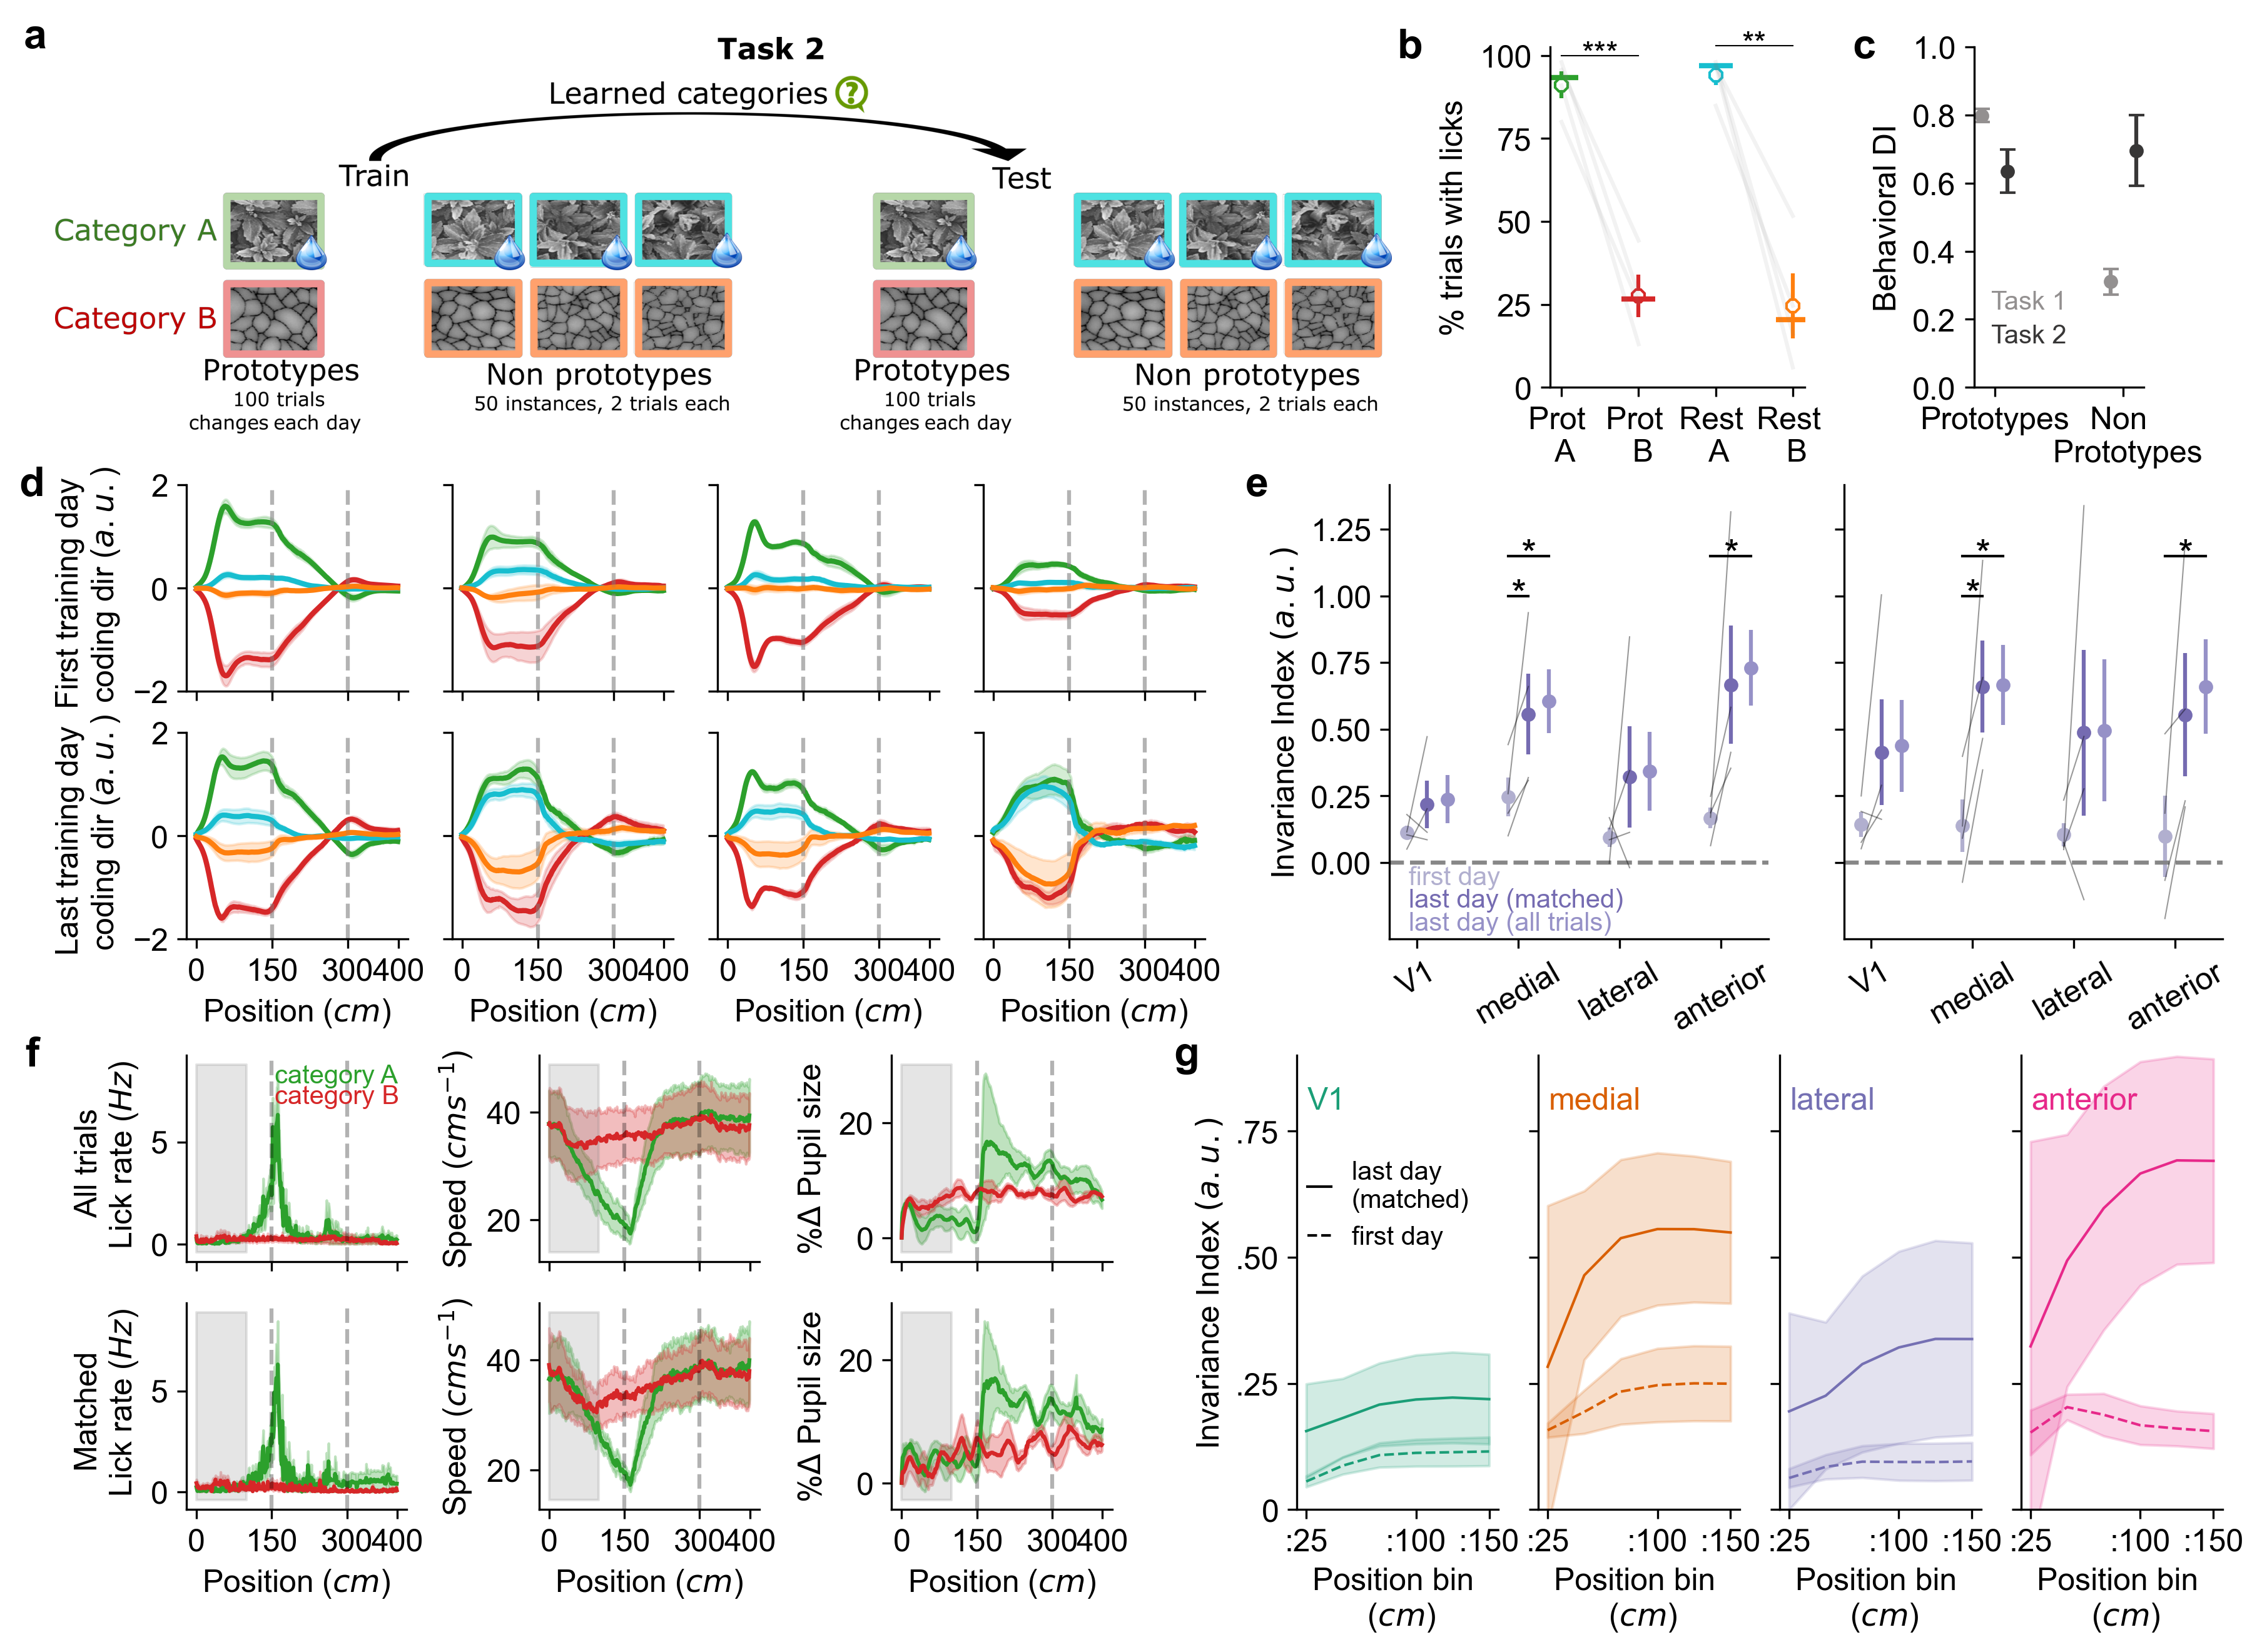

In [26]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig1 = plt.figure(figsize=(14, 10), dpi=300)
grid = GridSpec(6, 4, figure=fig1)
## add all subplots
row1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[0:2, :4], width_ratios=[1.5, .3, .2], wspace=0.3)
row2 = GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[2:4, :4], width_ratios=[1.1, .9])
cds = GridSpecFromSubplotSpec(2, 4, subplot_spec=row2[0, 0])
cd_quant = GridSpecFromSubplotSpec(1, 2, subplot_spec=row2[0, 1])
row3 = GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[4:6, :4], width_ratios=[1,1])
#row3_col0 = GridSpecFromSubplotSpec(2, 1, subplot_spec=row3[0, 0])
#logreg = GridSpecFromSubplotSpec(1, 2, subplot_spec=row3_col0[0, 0])
across_corridor = GridSpecFromSubplotSpec(1, 4, subplot_spec=row3[0, 1])
behav_match = GridSpecFromSubplotSpec(2, 3, subplot_spec=row3[0, 0], wspace=0.6)
img_axs = fig1.add_subplot(row1[0, 0])
show_image(img_axs, r"C:\Users\labadmin\Pictures\task2.png")
move_axis_2(img_axs, hdx=-0.05, vdx=0.025, heightdx=1.05, widthdx=1.05)
avg_axs = fig1.add_subplot(row1[0, 1])
move_axis_2(avg_axs, heightdx=.75, vdx=0.07, hdx=-.03)
task_comp = fig1.add_subplot(row1[0, 2])
move_axis_2(task_comp, heightdx=.75, vdx=0.07, hdx=-.03)
lick_averages(behavior_df, avg_axs, lines=True, stat_test=True, alpha=1)
plot_behav_dis(task_comp, behavior_df, first100df)
cds_axs = []
for rows in range(cds.nrows):
    for cols in range(cds.ncols):
        if rows == 0 and cols == 0:
            ax = fig1.add_subplot(cds[rows, cols])
        else: 
            ax = fig1.add_subplot(cds[rows, cols], sharex=cds_axs[0], sharey=cds_axs[0])
        if cols != 0:
            ax.tick_params(labelleft=False)
        else:
            if rows == 0:
                ax.set_ylabel("First training day \n coding dir ($a.u.$)")
            else:
                ax.set_ylabel("Last training day \n coding dir ($a.u.$)")
        ax.set_ylim(-2, 2)
        ax.set_xticks([0, 150, 300, 400])
        if rows == 0:
            ax.tick_params(labelbottom=False)
        else:
            ax.set_xlabel("Position ($cm$)")
        cds_axs.append(ax)
for ax in cds_axs:
    move_axis_2(ax, vdx=0.04)
for a, area in enumerate(areas):
    for ttype in range(4):
        plot_cds(first_day_cds, ttype, a, 0, cds_axs[a], references=True)
        plot_cds(last_day_cds, ttype, a, 0, cds_axs[a+4], references=True)
ax1 = fig1.add_subplot(cd_quant[0, 0])
ax2 = fig1.add_subplot(cd_quant[0, 1], sharey=ax1)
move_axis_2(ax1, heightdx=1, vdx=0.04)
move_axis_2(ax2, heightdx=1, vdx=0.04)
ax2.tick_params(labelleft=False)
gi_ax = [ax1, ax2]
gis_first, dis_first, gen_first = compute_gi(first_day_cds, 100)
gis_last_m, dis_last_m, gen_last_m = compute_gi(last_day_matched_cds, 100)
gis_last, dis_last, gen_last = compute_gi(last_day_cds, 100)
plot_gi_comparison_wcontrol(gis_first, gis_last_m,  gis_last, gi_ax)
for ax in gi_ax:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
matched_f_axs = []
for row in range(behav_match.nrows):
    for col in range(behav_match.ncols):
        if row == 0 and col == 0:
            ax = fig1.add_subplot(behav_match[row, col])
            ax.tick_params(labelbottom=False)
            matched_f_axs.append(ax)
        else:
            ax = fig1.add_subplot(behav_match[row, col], sharex=matched_f_axs[0])
            matched_f_axs.append(ax)
            if row == 0:
                ax.tick_params(labelbottom=False)
for i_f, f in enumerate(selected_features):
    plot_catvsbehav(non_matched_features[:,f, 0], non_matched_features[:,f, 1], f_labels[f], False, matched_f_axs[i_f], legend=False)
    plot_catvsbehav(matched_features[:,f, 0], matched_features[:,f, 1], f_labels[f], True, matched_f_axs[i_f+3], legend=False)
#for iax, ax in enumerate(matched_f_axs):
#    if iax < 3:
#        move_axis_2(ax, vdx=0.035, hdx=0.04)
#    else:
#        move_axis_2(ax, hdx=0.04)
matched_f_axs[3].set_ylabel(f"Matched \n {f_labels[selected_features[0]]}")
matched_f_axs[0].set_ylabel(f"All trials \n {f_labels[selected_features[0]]}")
matched_f_axs[0].text(.4,.9, "category A", ha='left', va='center', fontsize=10, 
                            color='tab:green', transform=matched_f_axs[0].transAxes)
matched_f_axs[0].text(.4,.8, "category B", ha='left', va='center', fontsize=10, 
                            color='tab:red', transform=matched_f_axs[0].transAxes)
across_axs = []
for row in range(across_corridor.nrows):
    for col in range(across_corridor.ncols):
        if row == 0 and col == 0:
            ax = fig1.add_subplot(across_corridor[row, col])
        else: 
            ax = fig1.add_subplot(across_corridor[row, col], sharex=across_axs[0], sharey=across_axs[0])
        #move_axis(ax, left=False, down=False, bottom_dx=0.05, height_dx=.5)
        ax.set_xticks([0, 3, 5], [':25', ':100', ':150'])
        across_axs.append(ax)
ctype = 0 
for ia, ax in enumerate(across_axs):
    if ia == 0:
        plot_cumulative_gi(ax, gis_first_bin, gis_last_bin, ia, ctype, errorbars=False, xlabel='Position bin \n ($cm$)', ylabel='Invariance Index $(a.u.)$')
    elif ia == 3:
        plot_cumulative_gi(ax, gis_first_bin, gis_last_bin, ia, ctype, errorbars=False, xlabel='Position bin \n ($cm$)')
    else:
        plot_cumulative_gi(ax, gis_first_bin, gis_last_bin, ia, ctype, errorbars=False, xlabel='Position bin \n ($cm$)')

custom_lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-'),   
    Line2D([0], [0], color='black', lw=1, linestyle='--')
]

across_axs[0].legend(custom_lines, ['last day\n(matched)', 'first day'], loc=(0,.55), fontsize=10, frameon=False, handlelength=.9)
#acc_axs = fig1.add_subplot(logreg[0, 0])
#betas_axs = fig1.add_subplot(logreg[0, 1])
#accuracy_plot(overall_acc, acc_axs)
#acc_axs.annotate(
#    "$d'$ selection window",           # The text
#    xy=(3, .6),                  # Arrow tip (x, y)
#    xytext=(6, .6),    # Text location (x_text, y_text)
#    arrowprops=dict(arrowstyle="->", color="black"),
#    fontsize=10, ha='left', va='center', transform=acc_axs.transData
#)
#betas_plot(overall_betas, betas_axs, legend=True)
#move_axis_2(acc_axs, vdx=0.03)
#move_axis_2(betas_axs, vdx=0.03)
add_panel_label(img_axs, 'a', x=-.015, y=1, fontsize=16, fontweight='bold')
add_panel_label(avg_axs, 'b', x=-0.55, y=1, fontsize=16, fontweight='bold')
add_panel_label(task_comp, 'c', x=-0.65, y=1, fontsize=16, fontweight='bold')
add_panel_label(cds_axs[0], 'd', x=-0.7, y=1, fontsize=16, fontweight='bold')
add_panel_label(gi_ax[0], 'e', x=-0.35, y=1, fontsize=16, fontweight='bold')
add_panel_label(matched_f_axs[0], 'f', x=-0.7, y=1, fontsize=16, fontweight='bold')
add_panel_label(across_axs[0], 'g', x=-0.55, y=1, fontsize=16, fontweight='bold')
sns.despine(fig=fig1, top=True, right=True, left=False, bottom=False)


In [187]:
def plot_matched_trials(overall_prob, catA_trials, catB_trials, ax, ax2):
    bins = np.linspace(0, 1, 11)
    histA, _ = np.histogram(overall_prob[catA_trials, 3], bins=bins, density=False)
    histB, _ = np.histogram(overall_prob[catB_trials, 3], bins=bins, density=False)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers, histA, width=np.diff(bins), alpha=0.4, color='tab:green', label='Category A')
    ax.bar(bin_centers, histB, width=np.diff(bins), alpha=0.4, color='tab:red', label='Category B')

    # Highlight overlap with hatching
    overlap = np.minimum(histA, histB)
    bars = ax.bar(bin_centers, overlap, width=np.diff(bins), alpha=0, label='Overlap', hatch='///')
    ymin, ymax = ax.get_ylim()
    # Set the y-limits to match the first panel
    ax2.set_ylim(ymin, ymax)
    # Plot overlap in right panel
    ax2.bar(bin_centers, overlap, width=np.diff(bins), color='gray', label='Overlap')

    # Remove left axis of right panel
    ax2.spines['left'].set_visible(False)
    ax2.yaxis.set_ticks([])
    ax2.tick_params(labelleft=False)

    fig = plt.gcf()
    import matplotlib.patches as mpatches
    arrow = mpatches.FancyArrowPatch(
        (.71, .72), (.84, .72),
        transform=fig.transFigure,
        arrowstyle="->", color='k', lw=1, mutation_scale=10
    )
    fig.patches.append(arrow)
    ax2.text(0.5, 0.7, "Behaviorally matched", ha='center', va='center', transform=ax2.transAxes, fontsize=10, color='k')
    ax.set_xlabel('Prob (Cat A)')
    ax2.set_xlabel('Prob (Cat A)')
    ax.set_ylabel('Trials')

In [188]:
catA = np.concatenate([mice[0].trial_dict["rewarded"], mice[0].trial_dict["rewarded test"]])
catB = np.concatenate([mice[0].trial_dict["non rewarded"], mice[0].trial_dict["non rewarded test"]])

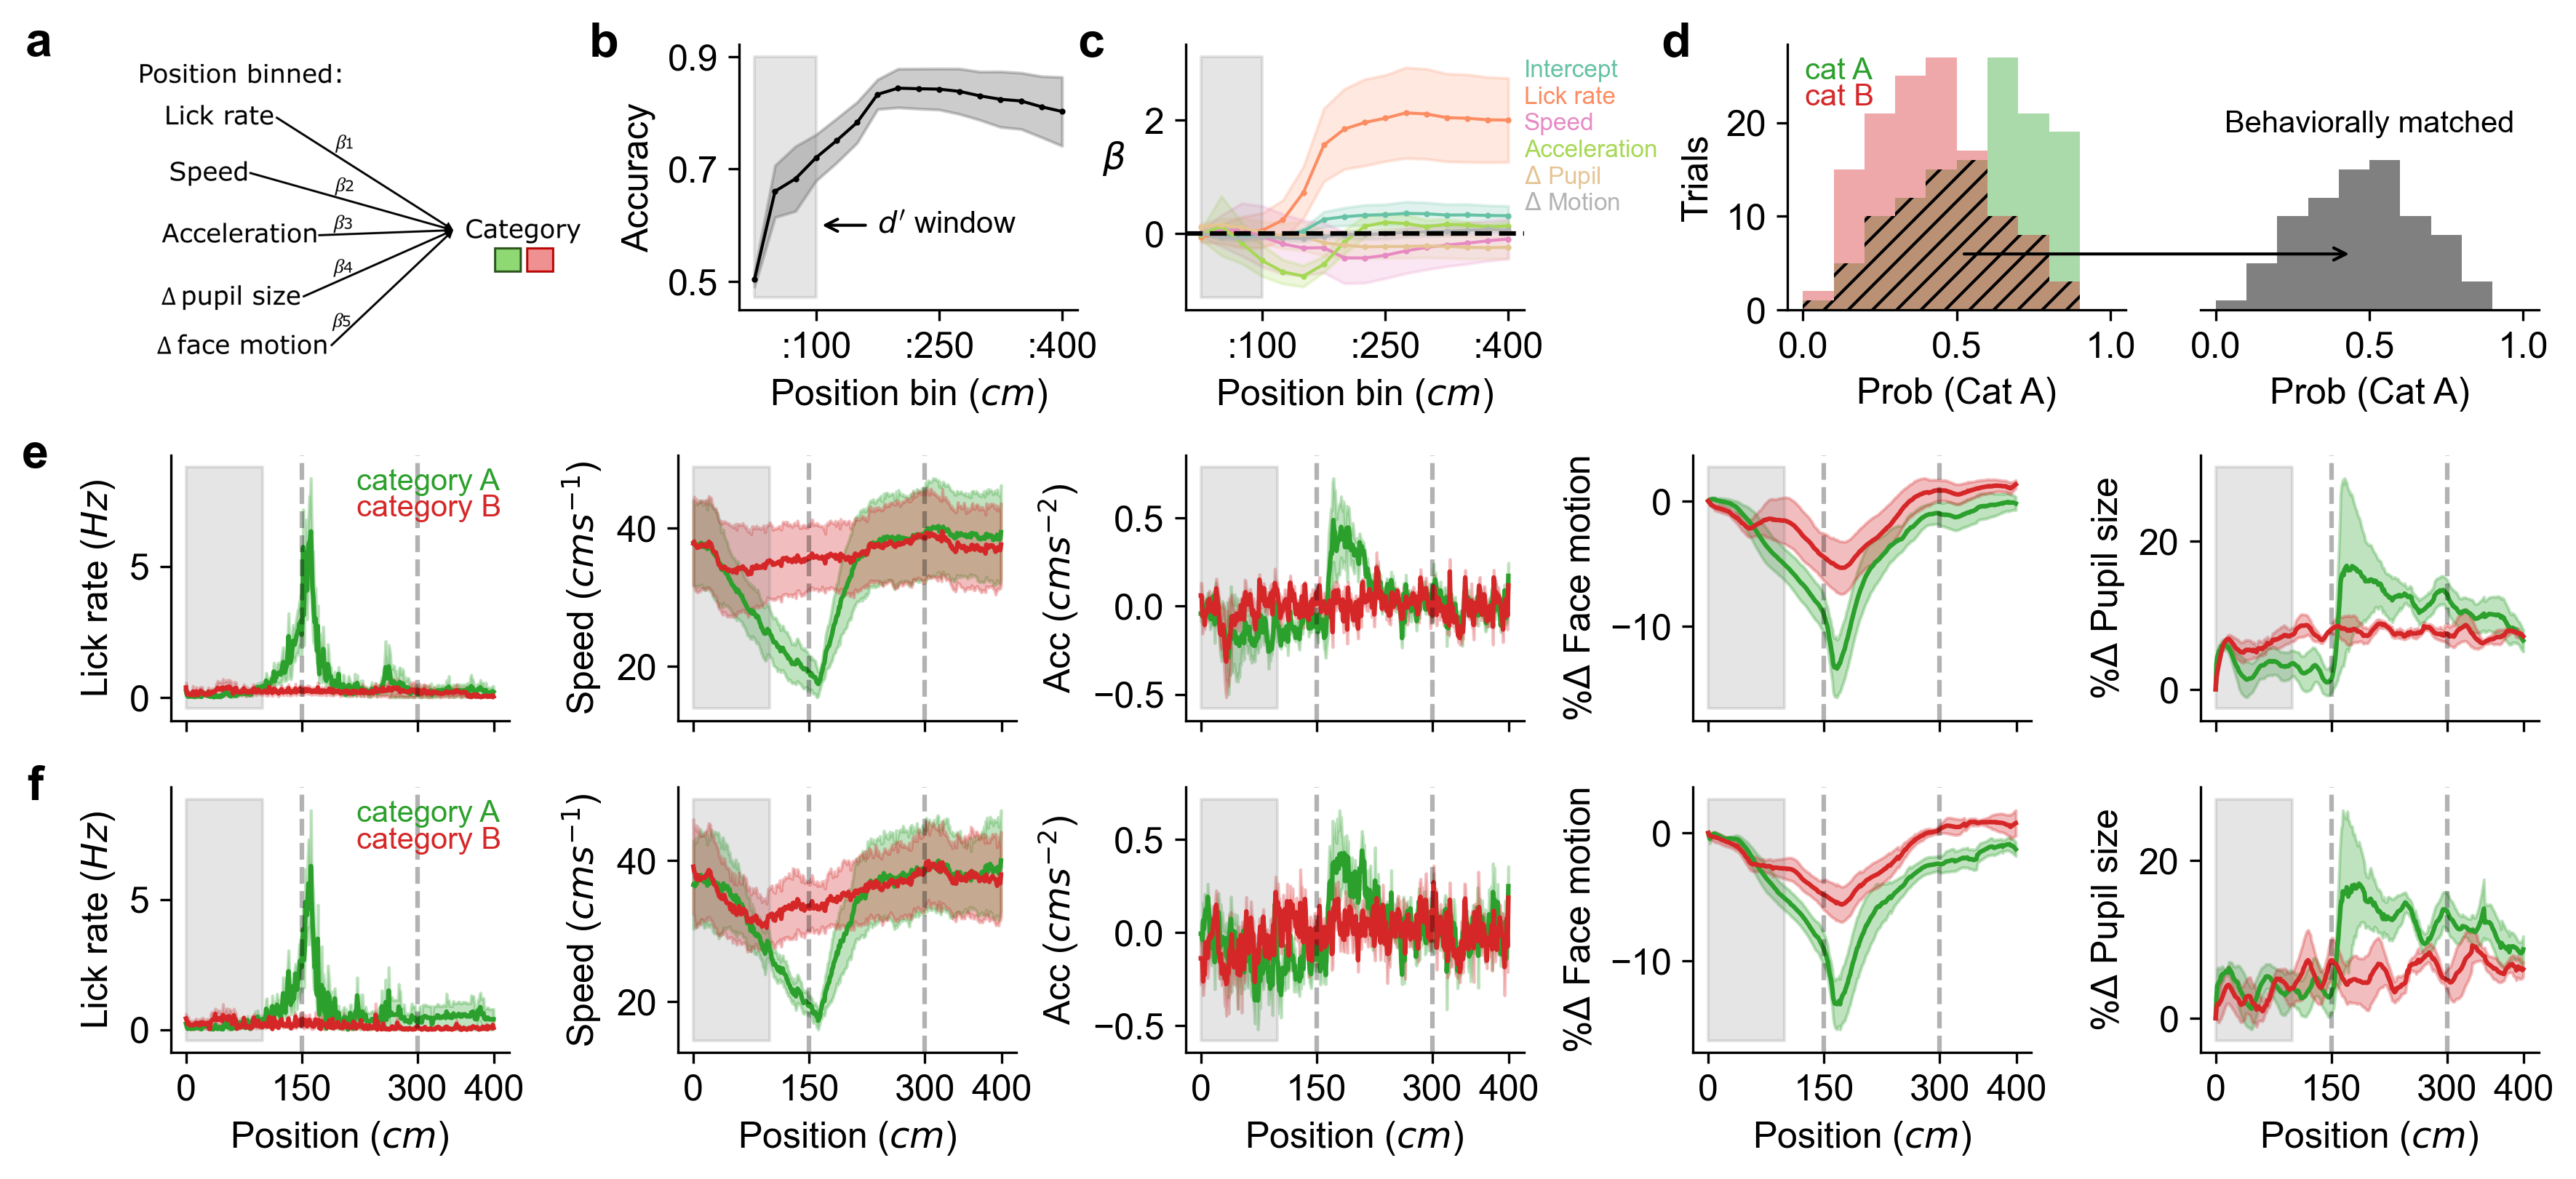

In [230]:
supp = plt.figure(figsize=(14, 6), dpi=300)
grid1 = GridSpec(3, 5, figure=supp, wspace=0.5, hspace=0.4)
nrows, ncols = grid1.get_geometry()
supp_axs = []
for row in range(nrows):
    for col in range(ncols):
        ax = supp.add_subplot(grid1[row, col])
        supp_axs.append(ax)

accuracy_plot(overall_acc, supp_axs[1])
supp_axs[1].annotate(
   "$d'$ window",           # The text
   xy=(3, .6),                  # Arrow tip (x, y)
    xytext=(6, .6),    # Text location (x_text, y_text)
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=10, ha='left', va='center', transform=supp_axs[1].transData
)
betas_plot(overall_betas, supp_axs[2], legend=True)
plot_matched_trials(overall_prob[0], catA, catB, supp_axs[3], supp_axs[4])
for i_f, f in enumerate(f_labels):
    plot_catvsbehav(non_matched_features[:,i_f,0], non_matched_features[:,i_f,1], f_labels[i_f], False, supp_axs[i_f+5], legend=False)
    supp_axs[i_f+5].set_xticklabels([])
    move_axis_2(supp_axs[i_f+5], vdx=-0.03)
    plot_catvsbehav(matched_features[:,i_f,0], matched_features[:,i_f,1], f_labels[i_f], True, supp_axs[i_f+10], legend=False)
move_axis_2(supp_axs[3], hdx=0.031)

supp_axs[3].text(0.05,.9, "cat A", ha='left', va='center', fontsize=10,
                            color='tab:green', transform=supp_axs[3].transAxes)
supp_axs[3].text(0.05,.8, "cat B", ha='left', va='center', fontsize=10,
                            color='tab:red', transform=supp_axs[3].transAxes)

supp_axs[5].text(.55,.9, "category A", ha='left', va='center', fontsize=10,
                            color='tab:green', transform=supp_axs[5].transAxes)
supp_axs[5].text(.55,.8, "category B", ha='left', va='center', fontsize=10,
                            color='tab:red', transform=supp_axs[5].transAxes)
supp_axs[10].text(.55,.9, "category A", ha='left', va='center', fontsize=10,
                            color='tab:green', transform=supp_axs[10].transAxes)
supp_axs[10].text(.55,.8, "category B", ha='left', va='center', fontsize=10,
                            color='tab:red', transform=supp_axs[10].transAxes)
show_image(supp_axs[0], r"C:\Users\labadmin\Pictures\reg_sk.png")
move_axis_2(supp_axs[0], hdx=-0.01, vdx=-0.05, heightdx=1.3, widthdx=1.3)
move_axis_2(supp_axs[1], hdx=0.02)
add_panel_label(supp_axs[0], 'a', x=-.23, y=1.07, fontsize=16, fontweight='bold')
add_panel_label(supp_axs[1], 'b', x=-.4, y=1, fontsize=16, fontweight='bold')
add_panel_label(supp_axs[2], 'c', x=-.28, y=1, fontsize=16, fontweight='bold')
add_panel_label(supp_axs[3], 'd', x=-.33, y=1, fontsize=16, fontweight='bold')
add_panel_label(supp_axs[5], 'e', x=-.4, y=1, fontsize=16, fontweight='bold')
add_panel_label(supp_axs[10], 'f', x=-.4, y=1, fontsize=16, fontweight='bold')